# 2\. szorgalmi házi feladat

In [262]:
# Imports
import numpy as np

#%tensorflow_version 2.x
#import tensorflow as tf
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [264]:
## Some utility classes & functions

# Converts data to torch tensors
# https://www.datacamp.com/tutorial/pytorch-tutorial-building-a-simple-neural-network-from-scratch

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X.astype(np.float32)) if type(X) != torch.Tensor else X
        self.Y = torch.from_numpy(Y.astype(np.float32)) if type(Y) != torch.Tensor else Y
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
   
    def __len__(self):
        return self.len

# Class that implements early stopping
# https://github.com/Bjarten/early-stopping-pytorch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            delta (float):  Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0    
        """
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# FNR & FPR
def multiclass_fpr_fnr(y_onehot_pred, y_onehot_true):
    pred_classes = np.argmax(y_onehot_pred, axis=1)
    class_cnt = y_onehot_pred.shape[1]
    y_true = np.argmax(y_onehot_true, axis=1)  # reverse one-hot

    confusion_mx = np.bincount(y_true * class_cnt + pred_classes,
                               minlength=class_cnt*class_cnt)\
                     .reshape((class_cnt, class_cnt))

    per_class_true_pos = np.diagonal(confusion_mx)

    per_class_true_pos_plus_false_pos = np.sum(confusion_mx, axis=0)
    per_class_false_pos = per_class_true_pos_plus_false_pos - per_class_true_pos

    per_class_true_pos_plus_false_neg = np.sum(confusion_mx, axis=1)
    per_class_false_neg = per_class_true_pos_plus_false_neg - per_class_true_pos

    per_class_true_neg = np.sum(confusion_mx) - \
                         (per_class_true_pos_plus_false_pos + per_class_false_neg)

    # to avoid warning when dividing with 0 in case of 0/0
    summed_fpr = np.sum(np.divide(per_class_false_pos,
                                  per_class_false_pos + per_class_true_neg,
                                  out=np.zeros(per_class_false_pos.shape),
                                  where=per_class_true_pos_plus_false_pos!=0))
        
    summed_fnr = np.sum(np.divide(per_class_false_neg,
                                  per_class_true_pos_plus_false_neg,
                                  out=np.zeros(per_class_false_neg.shape),
                                  where=per_class_true_pos_plus_false_neg!=0))

    return (summed_fpr / class_cnt), (summed_fnr / class_cnt)

## **Regressziós feladat**

RegModel(
  (0): Linear(in_features=32, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=30, bias=True)
  (3): ReLU()
  (4): Linear(in_features=30, out_features=1, bias=True)
)

Training NN...
Finished. Number of epochs: 424

Evaluation on test dataset:
	MSE: 1.7000492811203003
	MAE: 0.8270156979560852

Pred. | Truth | Abs. err.
13.6  |  14.0 |  0.4
10.0  |  11.0 |  1.0
15.9  |  17.0 |  1.1
15.6  |  15.0 |  0.6
13.7  |  15.0 |  1.3
 7.4  |   8.0 |  0.6
13.5  |  14.0 |  0.5
11.8  |  13.0 |  1.2
13.5  |  14.0 |  0.5
12.8  |  13.0 |  0.2


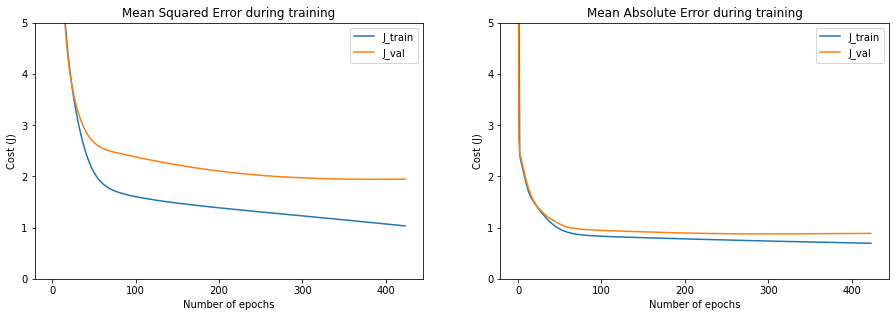

In [267]:
## Prepare dataset
f = open('student-por_prep.csv')
content = ''.join(f.readlines())
f.close()

lines = content.split("\n")
words = [line.split(";") for line in lines[1:-1]]    # ignore attribute names and last (empty) line

vals = [[float(item) for item in rec] for rec in words]
vals = np.array(vals, dtype=np.float32)

splitted = np.hsplit(vals, (vals.shape[1] - 1,))
features, labels = splitted[0], splitted[1].flatten()


## Distribute dataset
# shuffle rows
p = np.random.permutation(len(labels))
features, labels = features[p], labels[p]

# distribute elements
n_samp = len(features)
distr = (0.5, .25, .25)

distr = tuple(np.add.accumulate(np.array(distr) * n_samp, dtype=np.int32) + 1)
distr = np.insert(distr, 0, 0)  # indexing start at 0
ind1, ind2, ind3 = (np.s_[distr[i]:distr[i+1]] for i in range(len(distr) - 1))  # ngrams

x_unnorm_train, y_train = features[ind1], labels[ind1]

x_unnorm_val, y_val = features[ind2], labels[ind2]

x_unnorm_test, y_test = features[ind3], labels[ind3]


## normalize dataset
per_feature_min = x_unnorm_train.min(axis=0)
per_feature_max = x_unnorm_train.max(axis=0)
per_feature_diff = (per_feature_max - per_feature_min)

x_train = (x_unnorm_train - per_feature_min) / per_feature_diff
x_val = (x_unnorm_val - per_feature_min) / per_feature_diff
x_test = (x_unnorm_test - per_feature_min) / per_feature_diff


## create data loaders/batches
batch_size = 16

train_data = Data(x_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)

val_data = Data(x_val, y_val)
val_dataloader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)


## create MLP regression model
class RegModel(nn.Sequential):
    def __init__(self, input_dim):
        super().__init__(
           nn.Linear(input_dim, 50),
           nn.Tanh(),
           nn.Linear(50, 30),
           nn.ReLU(),
           nn.Linear(30, 1))

reg_model = RegModel(x_train.shape[1])
print(reg_model)


## training the regression model
learning_rate = 0.001
optimizer = torch.optim.SGD(reg_model.parameters(), lr=learning_rate)
num_epochs = 800
patience = 40
verbose = False

mse_fn = nn.MSELoss()
mae_fn = nn.L1Loss()
train_mse_loss_history, train_mae_loss_history = [], []
val_mse_loss_history, val_mae_loss_history = [], []

early_stopping = EarlyStopping(patience=patience)

print()
print('Training NN...')
epoch_ct = 0
for epoch in range(num_epochs):
    epoch_ct += 1

    # iterate over training batches
    train_mse, train_mae = 0.0, 0.0
    for X_train, Y_train in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        output = reg_model(X_train)
        loss = mse_fn(output, Y_train.unsqueeze(-1))
        loss.backward()
        optimizer.step()

        # since PyTorch loss functions accumulate the data (reduction='mean') for each batch
        # we need to multiply by batch size
        train_mse += output.shape[0] * loss.item()
        train_mae += output.shape[0] * mae_fn(output, Y_train.unsqueeze(-1)).item()

    # calculate train MSE and MAE over epoch
    mse_loss, mae_loss = train_mse / len(x_train), train_mae / len(x_train)
    train_mse_loss_history.append(mse_loss)
    train_mae_loss_history.append(mae_loss)

    # iterate over validation batches
    val_mse, val_mae = 0.0, 0.0
    for X_val, Y_val in val_dataloader:
        val_output = reg_model(X_val)
        val_mse += val_output.shape[0] * mse_fn(val_output, Y_val.unsqueeze(-1)).item()
        val_mae += val_output.shape[0] * mae_fn(val_output, Y_val.unsqueeze(-1)).item()

    # calculate validation MSE and MAE over epoch
    val_mse_loss, val_mae_loss = val_mse / len(x_val), val_mae / len(x_val)
    val_mse_loss_history.append(val_mse_loss)
    val_mae_loss_history.append(val_mae_loss)
    
    if verbose:
        print(f'Epoch {epoch + 1}/{num_epochs} ==> loss: {round(mse_loss, 4)} '
                                               f'- mean_absolute_error: {round(mae_loss, 4)} '
                                               f'- val_loss: {round(val_mse_loss, 4)} '
                                               f'- val_mean_absolute_error {round(val_mae_loss, 4)}')

    # early stop in case validation loss fn. stops decreasing
    early_stopping(val_mse_loss)
    if early_stopping.early_stop:
        break
print(f'Finished. Number of epochs: {epoch_ct}')


## plotting training metrics
plt.figure(figsize=(32, 16))

plt.subplot(3, 4, 1)
plt.plot(train_mse_loss_history, label="J_train")
plt.plot(val_mse_loss_history, label="J_val")
plt.ylim((0,5))
plt.xlabel("Number of epochs")
plt.ylabel("Cost (J)")
plt.legend()
plt.title("Mean Squared Error during training")

plt.subplot(3, 4, 2)
plt.plot(train_mae_loss_history, label="J_train")
plt.plot(val_mae_loss_history, label="J_val")
plt.ylim((0,5))
plt.xlabel("Number of epochs")
plt.ylabel("Cost (J)")
plt.legend()
plt.title("Mean Absolute Error during training")


## evaluating & testing the model
print()
print('Evaluation on test dataset:')
with torch.no_grad():
    # evaluating
    test_output = reg_model(torch.from_numpy(x_test))
    test_mse = mse_fn(test_output, torch.from_numpy(y_test).unsqueeze(-1)).item()
    test_mae = mae_fn(test_output, torch.from_numpy(y_test).unsqueeze(-1)).item()
    print(f'\tMSE: {test_mse}')
    print(f'\tMAE: {test_mae}')

    # testing for a few, random values
    samp_size = 10
    rand_idxs = np.random.randint(len(x_test), size=samp_size)
    predictions = reg_model(torch.from_numpy(x_test[rand_idxs])).flatten()
    ground_t_labels = y_test[rand_idxs]

    print()
    print("Pred. | Truth | Abs. err.")
    for (p, g) in zip(predictions, ground_t_labels):
      print(f"{p:4.1f}  |  {g:4.1f} | {abs(p - g):4.1f}")

## **Klasszifikációs feladat**

ClModel(
  (0): Linear(in_features=32, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=30, bias=True)
  (3): ReLU()
  (4): Linear(in_features=30, out_features=3, bias=True)
  (5): Softmax(dim=1)
)

Training NN...
Finished. Number of epochs: 360

Evaluation on test dataset:
	CE:  0.5513136386871338
	ACC: 0.7654320987654321
	FPR: 0.12368295019157088
	FNR: 0.23430830039525694


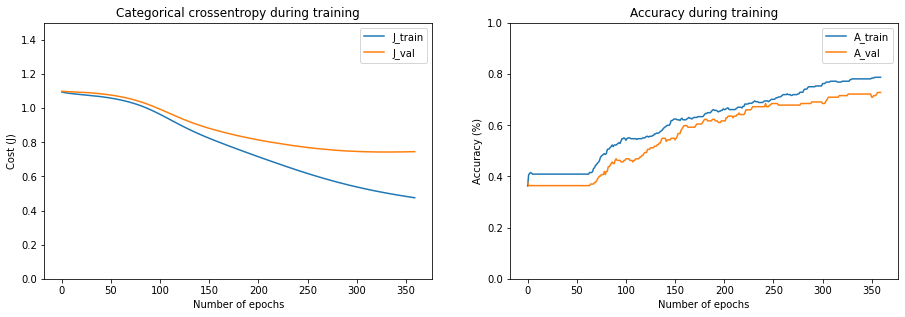

In [275]:
## dataset conversion to classification dataset
cat_count = 3
ideal_group_size = len(y_train) / cat_count
ideal_group_counts = ideal_group_size * np.arange(1,cat_count)

uniqes, counts = np.unique(y_train, return_counts=True)

# lowest difference from ideal divison point
div_idx = np.argmin(np.absolute(np.add.accumulate(counts) - ideal_group_counts[:,None]), axis=1)

# matrix to compare which category a value falls into
div_vals = uniqes[div_idx]
div_vals_lower = np.insert(div_vals, 0, 0)
div_vals_upper = np.append(div_vals, uniqes[-1])

# used to categorize every value, based on the divison points
# calculated from the 'train' dataset (y_train)
def categorize(mx): return np.argmax( (div_vals_lower[:,None] < mx) &
                                      (mx <= div_vals_upper[:,None]),
                                    axis=0 )

# categorize
to_categorize = (y_train, y_val, y_test)
y_cat_train, y_cat_val, y_cat_test = (categorize(mx) for mx in to_categorize)

# one-hot encode
# ! no need for it because of how nn.NLLLoss works, so I set it to identity
# https://discuss.pytorch.org/t/categorical-cross-entropy-loss-function-equivalent-in-pytorch/85165/4
conv_fn = lambda x, _ : x # F.one_hot
to_encode = (y_cat_train, y_cat_val, y_cat_test)
y_onehot_train, y_onehot_val, y_onehot_test = (conv_fn(torch.tensor(mx), cat_count) for mx in to_encode)


## create data loaders/batches
batch_size = 32

train_data = Data(x_train, y_onehot_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)

val_data = Data(x_val, y_onehot_val)
val_dataloader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)


## create classification model
class ClModel(nn.Sequential):
    def __init__(self, input_dim):
        super().__init__(
           nn.Linear(input_dim, 50),
           nn.Tanh(),
           nn.Linear(50, 30),
           nn.ReLU(),
           nn.Linear(30, cat_count),
           nn.Softmax(dim=1))

cl_model = ClModel(x_train.shape[1])
print(cl_model)


## training the regression model
learning_rate = 0.008
optimizer = torch.optim.SGD(cl_model.parameters(), lr=learning_rate)
num_epochs = 1000
patience = 30
verbose = False

loss_fn = lambda x, y : nn.NLLLoss()(torch.log(x), y)
train_ce_loss_history, train_acc_loss_history = [], []
val_ce_loss_history, val_acc_loss_history = [], []

early_stopping = EarlyStopping(patience=patience)

print()
print('Training NN...')

epoch_ct = 0
for epoch in range(num_epochs):
    epoch_ct += 1

    # iterate over training batches
    train_ce, train_acc = 0.0, 0
    for X_train, Y_train in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        output = cl_model(X_train)
        loss = nn.NLLLoss()(torch.log(output), Y_train)
        loss.backward()
        optimizer.step()

        # since PyTorch loss functions accumulate the data (reduction='mean') for each batch
        # we need to multiply by batch size
        train_ce += output.shape[0] * loss.item()
        # count how many predictions (labels) are correct
        train_acc += (output.argmax(dim=1) == Y_train).sum().item()

    # calculate train crossentropy and accuracy over epoch
    train_ce_loss, train_acc_loss = train_ce / len(x_train), train_acc / len(x_train)
    train_ce_loss_history.append(train_ce_loss)
    train_acc_loss_history.append(train_acc_loss)


    # iterate over validation batches
    val_ce, val_acc = 0.0, 0
    for X_val, Y_val in val_dataloader:
        val_output = cl_model(X_val)
        val_ce += val_output.shape[0] * nn.NLLLoss()(torch.log(val_output), Y_val).item()
        val_acc += (val_output.argmax(dim=1) == Y_val).sum().item()

    # calculate validation crossentropy and accuracy over epoch
    val_ce_loss, val_acc_loss = val_ce / len(x_val), val_acc / len(x_val)
    val_ce_loss_history.append(val_ce_loss)
    val_acc_loss_history.append(val_acc_loss)
    
    if verbose:
        print(f'Epoch {epoch + 1}/{num_epochs} ==> loss: {round(train_ce_loss, 4)} '
                                               f'- categorical_accuracy: {round(train_acc_loss, 4)} '
                                               f'- val_loss: {round(val_ce_loss, 4)} '
                                               f'- val_categorical_accuracy {round(val_acc_loss, 4)}')

    # early stop in case validation loss fn. stops decreasing
    early_stopping(val_ce_loss)
    if early_stopping.early_stop:
        break

print(f'Finished. Number of epochs: {epoch_ct}')


## plotting training metrics
plt.figure(figsize=(32, 16))

plt.subplot(3, 4, 1)
plt.plot(train_ce_loss_history, label="J_train")
plt.plot(val_ce_loss_history, label="J_val")
plt.ylim((0,1.5))
plt.xlabel("Number of epochs")
plt.ylabel("Cost (J)")
plt.legend()
plt.title("Categorical crossentropy during training")

plt.subplot(3, 4, 2)
plt.plot(train_acc_loss_history, label="A_train")
plt.plot(val_acc_loss_history, label="A_val")
plt.ylim((0,1))
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy during training")


## evaluating
print()
print('Evaluation on test dataset:')
with torch.no_grad():
    test_output = cl_model(torch.from_numpy(x_test))
    test_y = torch.from_numpy(y_cat_test)

    test_ce = nn.NLLLoss()(torch.log(test_output), test_y).item()
    test_acc = (test_output.argmax(dim=1) == test_y).sum().item() / len(x_test)

    test_fpr, test_fnr = multiclass_fpr_fnr(test_output.numpy(), F.one_hot(test_y).numpy())

    print(f'\tCE:  {test_ce}')
    print(f'\tACC: {test_acc}')
    print(f'\tFPR: {test_fpr}')
    print(f'\tFNR: {test_fnr}')
